In [1]:
!git clone https://github.com/uber-research/atari-model-zoo
import os
os.chdir("/content/atari-model-zoo")
import atari_zoo

Cloning into 'atari-model-zoo'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 159 (delta 41), reused 104 (delta 30), pack-reused 33
Receiving objects: 100% (159/159), 20.00 MiB | 27.31 MiB/s, done.
Resolving deltas: 100% (46/46), done.
tf2onnx not installed, you will not be able to export to onnx
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3047424/45929032 bytes (6.6%)6823936/45929032 bytes (14.9%)10690560/45929032 bytes (23.3%)14573568/45929032 bytes (31.7%)18399232/45929032 bytes (40.1%)22315008/45929032 bytes (4

## Download trained model and precomputed rollout data

In [2]:
import atari_zoo
from atari_zoo import MakeAtariModel
from pylab import *

algo = "rainbow" #or try.... es, ga, dqn, a2c, apex
env = "SeaquestNoFrameskip-v4"  #or try... ZaxxonNoFrameSkip-v4
run_id = 2
tag = "final"
m = MakeAtariModel(algo,env,run_id,tag)()

# get observations, frames, ram state, and neural representations from a representative rollout
obs = m.get_observations()
frames = m.get_frames()
ram = m.get_ram()
rep = m.get_representation()

Model path: gs://download-dopamine-rl/lucid/rainbow/Seaquest/2/graph_def.pb
Data path: https://dgqeqexrlnkvd.cloudfront.net/zoo/rainbow/SeaquestNoFrameskip-v4/model2_final_rollout.npz
Log path: https://dgqeqexrlnkvd.cloudfront.net/zoo/rainbow/checkpoints/SeaquestNoFrameskip-v4_2


## Display one RGB frame and corresponding pre-processed observation fed into deep NN


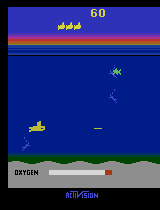

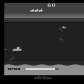

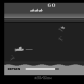

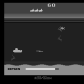

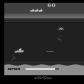

In [3]:
from IPython.display import Image, display
import numpy as np
import PIL

idx = 100
frame = frames[idx]
_obs = obs[idx].transpose((2,0,1))

#display RGB frame 
display(PIL.Image.fromarray(frame))

#display T-3, T-2, T-1, Now frames of observation fed into deep neural network
for i in range(4):
  _obsf = (np.tile(_obs[i,...,np.newaxis],(1,1,3)) * 255).astype(np.uint8)
  display(PIL.Image.fromarray(_obsf))

## Visualize RAM state across this rollout


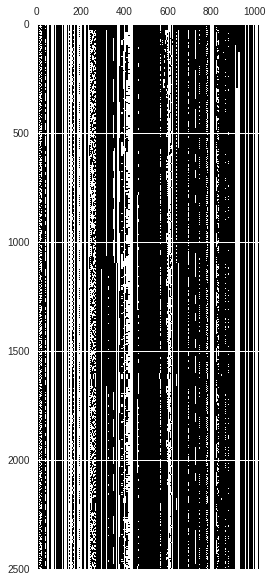

In [62]:
ram = np.array(ram)
#get ram state across all frames of the observation
bin_array = np.zeros((ram.shape[0],128*8),dtype=np.uint8)

#convert from integer to bits
for idx in range(ram.shape[0]):
    state = ram[idx]
    
    binary = m.ram_state_to_bits(state)
    binary = [int(k) for k in binary]
    
    bin_array[idx]=binary

gray()
matshow(bin_array)

## Visualize neural representation across rollout for this rollout 

Activations of the 512 fully-connected neurons for each observation

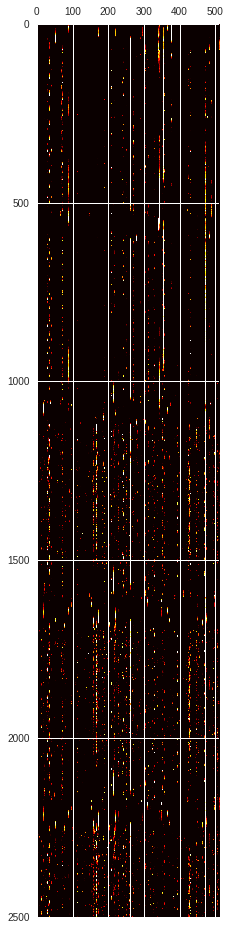

In [63]:
hot()
matshow(rep,vmax=3,vmin=0)

## Visualizing Top Patches for  Sub-detecting Neuron

Requires GPU runtime to be enabled (Go to "Runtime" menu  -> "Change Runtime Type" option)

In [52]:
import atari_zoo.top_patches
algo = 'apex'
env = 'SeaquestNoFrameskip-v4' 
run_id = 2
observations, activations,frames = atari_zoo.top_patches.build_model_get_act(algo, env, run_id=run_id,which_layer=2)

Model path: https://dgqeqexrlnkvd.cloudfront.net/zoo/apex/SeaquestNoFrameskip-v4/model2_final.pb
Data path: https://dgqeqexrlnkvd.cloudfront.net/zoo/apex/SeaquestNoFrameskip-v4/model2_final_rollout.npz
Log path: https://dgqeqexrlnkvd.cloudfront.net/zoo/apex/checkpoints/SeaquestNoFrameskip-v4_2
Layer 2 deepq/q_func/convnet/Conv_2/Relu activations obtained. Shape (2501, 11, 11, 64)


In [66]:
#sub detector for apex run 2 Seaquest is feature 60
filter_id = 60

patches, picks, topleft = atari_zoo.top_patches.plot_topN_patches(activations, observations, which_filter=filter_id, which_layer=2,n=8,plot=False)

bottom left location in original obs: (66,22)
bottom left location in original obs: (66,30)
bottom left location in original obs: (66,30)
bottom left location in original obs: (50,-2)
bottom left location in original obs: (50,30)
bottom left location in original obs: (66,30)
bottom left location in original obs: (58,22)
bottom left location in original obs: (74,30)


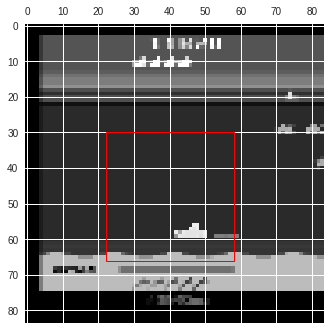

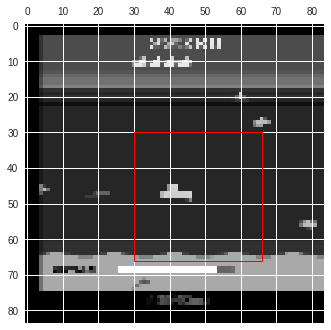

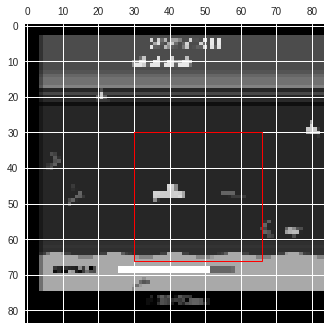

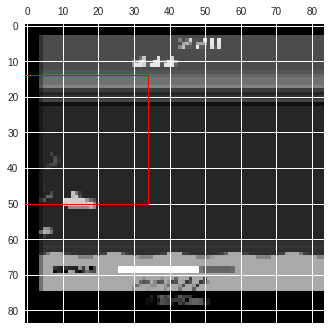

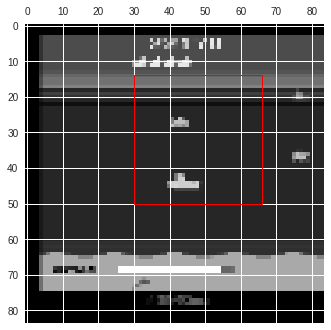

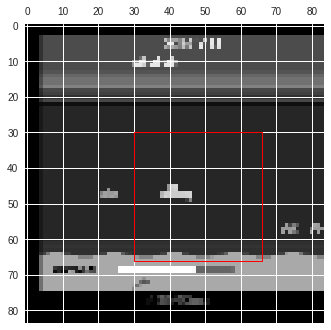

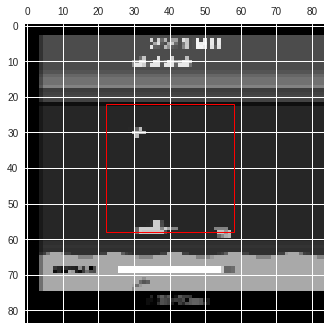

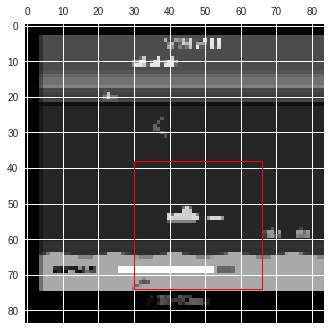

In [67]:
import matplotlib.patches as patches
from pylab import *

for pp, tl in zip(picks, topleft):
    #print(tl)
    #print(tuple(reversed(tl)))
    gray()
    fig, ax = subplots(1)
    ax.matshow(observations[pp,:,:,0])
    rect = patches.Rectangle(tuple(reversed(tl)),36,36,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)